In [1]:
import os
import cv2
import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

from keras.applications.vgg16 import VGG16
from keras.models import Model
from glob import glob

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/Data'
training_path = '/content/drive/MyDrive/Data/train'
testing_path = '/content/drive/MyDrive/Data/test'

Pneumonia_images = os.listdir(training_path + "/PNEUMONIA")
Normal_images = os.listdir(training_path + "/NORMAL")
COVID19_images = os.listdir(training_path + "/COVID19")

In [4]:
os.listdir(data_path)

['train', 'test']

In [5]:
os.listdir(training_path)

['COVID19', 'PNEUMONIA', 'NORMAL']

In [6]:
os.listdir(testing_path)

['COVID19', 'NORMAL', 'PNEUMONIA']

In [7]:
print(len(os.listdir(training_path+"/COVID19")))
print(len(os.listdir(training_path+"/NORMAL")))
print(len(os.listdir(training_path+"/PNEUMONIA")))

460
1266
3418


In [8]:
print(len(os.listdir(testing_path+"/COVID19")))
print(len(os.listdir(testing_path+"/NORMAL")))
print(len(os.listdir(testing_path+"/PNEUMONIA")))

116
321
855


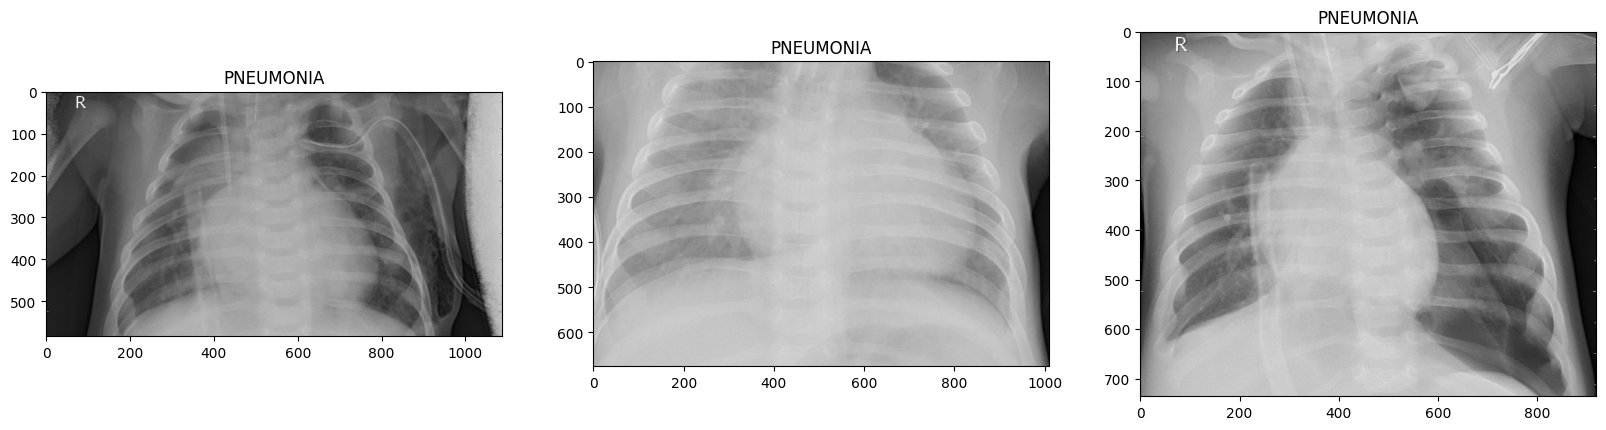

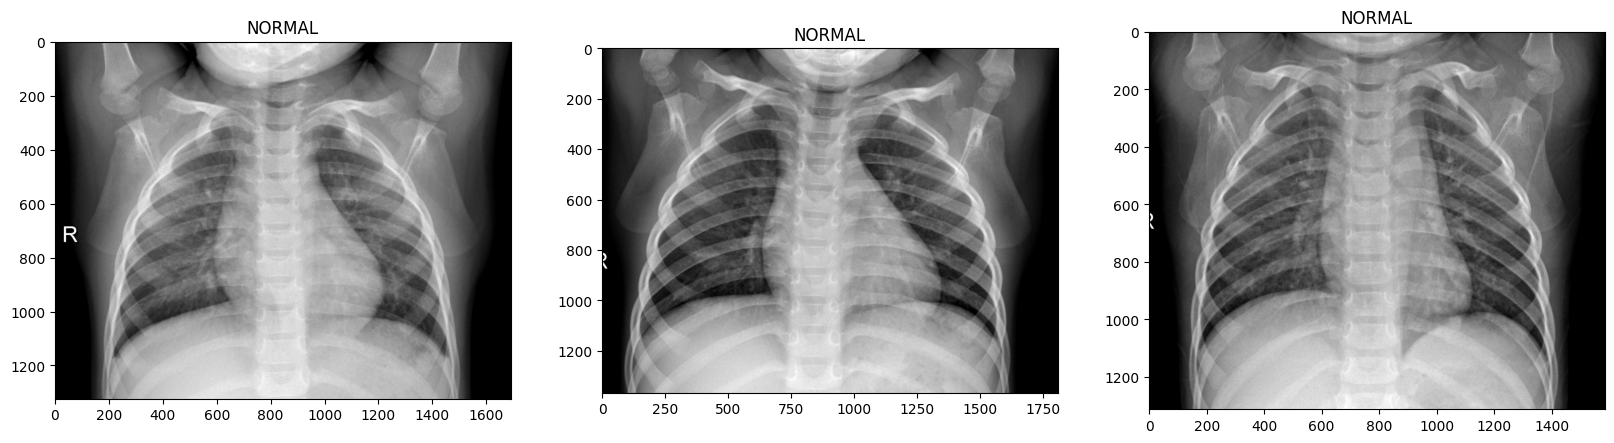

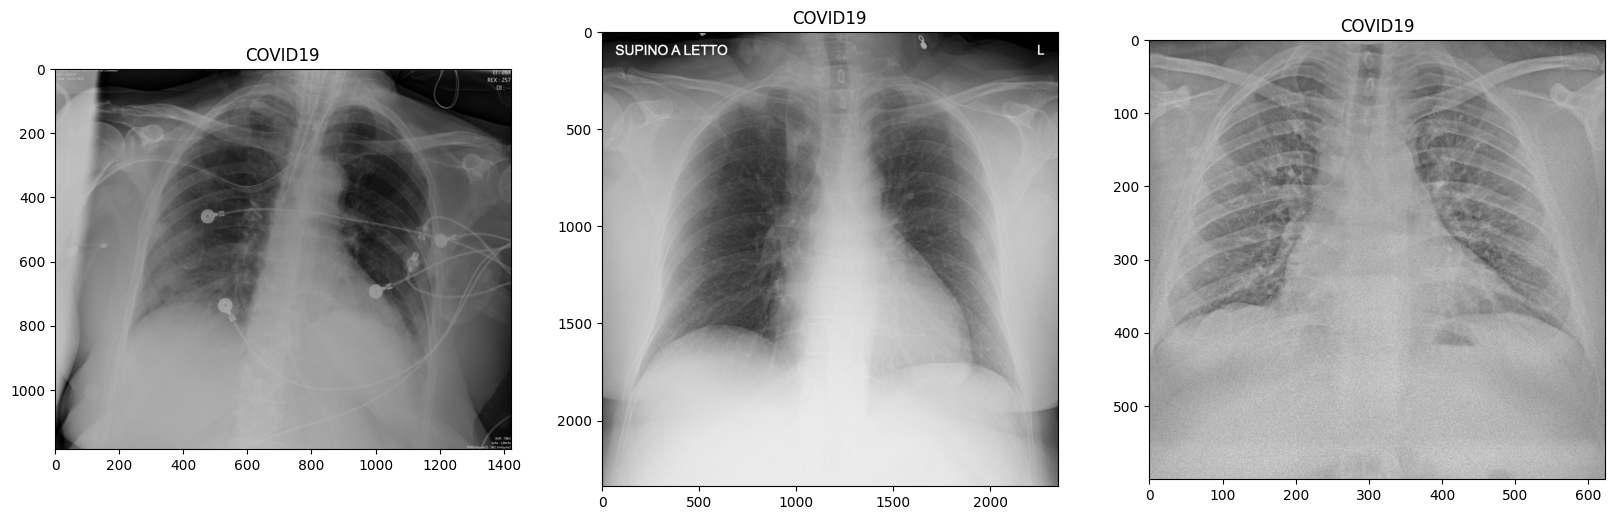

In [10]:
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(training_path + "/PNEUMONIA",Pneumonia_images[i])))
    plt.title("PNEUMONIA")

plt.show()
#plot NORMAL
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(training_path + "/NORMAL",Normal_images[i])))
    plt.title("NORMAL")

plt.show()
#plot
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(training_path + "/COVID19",COVID19_images[i])))
    plt.title("COVID19")

In [12]:
from sklearn.model_selection import train_test_split

IMAGE_SIZE = [224, 224]



train_datagen = ImageDataGenerator(rescale = 1./225,
                                   samplewise_center = True,
                                   samplewise_std_normalization = True,
                                  rotation_range = 20,
                                  horizontal_flip = True,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./225)

train_generator = train_datagen.flow_from_directory(directory = training_path,
                                                        target_size = tuple(IMAGE_SIZE),
                                                        batch_size = 64,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(directory = testing_path,
                                                        target_size = tuple(IMAGE_SIZE),
                                                        batch_size = 64,
                                                        class_mode = 'categorical',
                                                        shuffle = False)


Found 5144 images belonging to 3 classes.
Found 1292 images belonging to 3 classes.


1. **VGG16 MODEL**

In [13]:
vgg16 = VGG16(input_shape= IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)

for layer in vgg16.layers:
    layer.trainable = False

vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [14]:
no_of_categories = glob(training_path + '/*')
print(no_of_categories)

['/content/drive/MyDrive/Data/train/COVID19', '/content/drive/MyDrive/Data/train/PNEUMONIA', '/content/drive/MyDrive/Data/train/NORMAL']


In [15]:
x =  AveragePooling2D(pool_size = (4, 4))(vgg16.output)
x = Flatten()(x)
x = Dense(units = 64, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(units = 512, activation = 'relu')(x)
predictions = Dense(units = len(no_of_categories), activation = tf.nn.softmax)(x)
model = Model(inputs = vgg16.input, outputs = predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

EarlyStoppingCallBack = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=5)
CheckPointCallback = ModelCheckpoint("chest-xray.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [17]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
hist = model.fit(train_generator,
                    epochs = 10, steps_per_epoch = 33,
                    validation_data= test_generator,
                    callbacks = [EarlyStoppingCallBack, CheckPointCallback],
                    verbose = 1)

Epoch 1/10
33/33 [==============================] - ETA: 0s - loss: 0.5269 - accuracy: 0.7679 


Epoch 1: val_loss did not improve from 0.82570
33/33 [==============================] - 1446s 44s/step - loss: 0.5269 - accuracy: 0.7679 - val_loss: 1.1860 - val_accuracy: 0.6638
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8769 


Epoch 2: val_loss did not improve from 0.82570
33/33 [==============================] - 1388s 42s/step - loss: 0.3410 - accuracy: 0.8769 - val_loss: 1.0086 - val_accuracy: 0.6918
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.8793 


Epoch 3: val_loss did not improve from 0.82570
33/33 [==============================] - 1409s 43s/step - loss: 0.3047 - accuracy: 0.8793 - val_loss: 0.9859 - val_accuracy: 0.6995
Epoch 4/10
33/33 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.8935 


Epoch 4: val_loss did not improve from 0.82570
33/33 [==============================] - 1432s 44s/step - loss: 0.2673 - accuracy: 0.8935 - val_loss: 1.3272 - val_accuracy: 0.6887
Epoch 5/10
33/33 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9040 


Epoch 5: val_loss did not improve from 0.82570
33/33 [==============================] - 1414s 43s/step - loss: 0.2411 - accuracy: 0.9040 - val_loss: 1.2491 - val_accuracy: 0.6809
Epoch 6/10
33/33 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.8977 


Epoch 6: val_loss did not improve from 0.82570
33/33 [==============================] - 1412s 43s/step - loss: 0.2567 - accuracy: 0.8977 - val_loss: 1.3841 - val_accuracy: 0.4946
Epoch 7/10
33/33 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9138 


Epoch 7: val_loss did not improve from 0.82570
33/33 [==============================] - 1430s 44s/step - loss: 0.2248 - accuracy: 0.9138 - val_loss: 1.4411 - val_accuracy: 0.6957
Epoch 8/10
33/33 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9105 


Epoch 8: val_loss did not improve from 0.82570
33/33 [==============================] - 1388s 42s/step - loss: 0.2562 - accuracy: 0.9105 - val_loss: 1.5264 - val_accuracy: 0.4814
Epoch 9/10
33/33 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9175 


Epoch 9: val_loss did not improve from 0.82570
33/33 [==============================] - 1412s 43s/step - loss: 0.2225 - accuracy: 0.9175 - val_loss: 1.1662 - val_accuracy: 0.6491
Epoch 10/10
33/33 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9171 


Epoch 10: val_loss did not improve from 0.82570
33/33 [==============================] - 1433s 44s/step - loss: 0.2181 - accuracy: 0.9171 - val_loss: 1.2941 - val_accuracy: 0.6576


In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

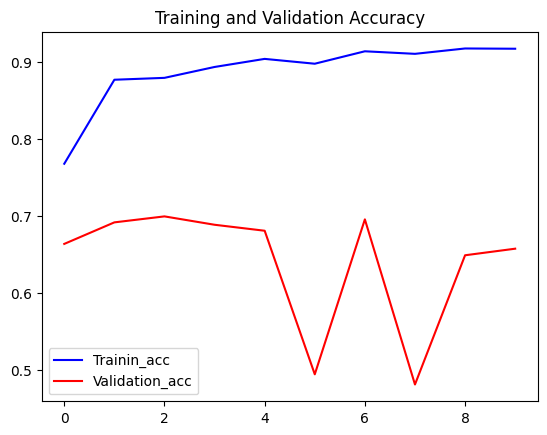

In [ ]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

In [ ]:
print("training_accuracy", hist.history['accuracy'][-1])
print("validation_accuracy", hist.history['val_accuracy'][-1])

training_accuracy 0.9171401262283325
validation_accuracy 0.657608687877655


21/21 [==============================] - 537s 25s/step


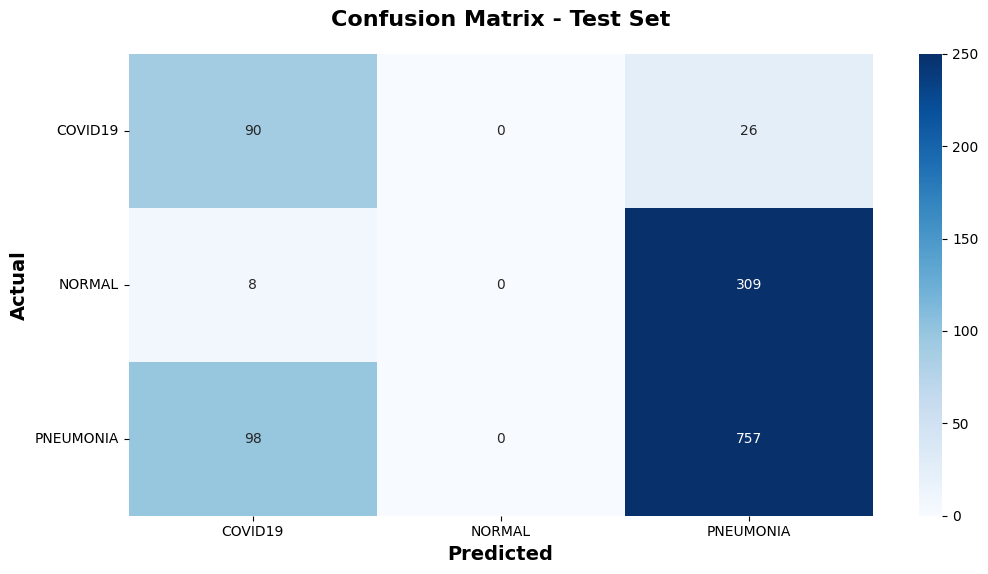

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ["COVID19", "NORMAL", "PNEUMONIA"]

y_pred = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.46      0.78      0.58       116
           1       0.00      0.00      0.00       317
           2       0.69      0.89      0.78       855

    accuracy                           0.66      1288
   macro avg       0.38      0.55      0.45      1288
weighted avg       0.50      0.66      0.57      1288



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
